In [1]:

import os
import shutil
import kagglehub
subhajournal_phishingemails_path = kagglehub.dataset_download('subhajournal/phishingemails')
print('Data source import complete.')


100%|██████████| 18.0M/18.0M [00:01<00:00, 17.9MB/s]

Extracting files...


Data source import complete.


# Phising Email torch RoBERTa+PEFT

---



https://www.kaggle.com/code/stpeteishii/twitch-reviews-torch-roberta


## About PEFT
PEFT (Parameter-Efficient Fine-Tuning) is a technique used in machine learning, particularly in the context of fine-tuning large pre-trained models like transformers (e.g., BERT, GPT, etc.) for specific tasks. The primary goal of PEFT is to reduce the number of parameters that need to be updated during the fine-tuning process, which significantly decreases the computational cost and memory usage while maintaining or even improving performance.

## Key Concepts of PEFT:
Efficiency: By focusing only on a subset of parameters, PEFT avoids the need to fine-tune all parameters of the model, making the process faster and less resource-intensive.

Memory and Computational Savings: PEFT drastically reduces the amount of GPU memory required, making it feasible to fine-tune very large models on smaller hardware setups.

Performance Maintenance: Despite fine-tuning fewer parameters, PEFT techniques are often able to achieve comparable or even superior performance to full fine-tuning.

Application Areas: PEFT is widely used in natural language processing (NLP), computer vision, and other AI tasks that involve large-scale models, allowing for efficient adaptation of general-purpose models to specific applications.

## Techniques Used in PEFT:
Adapters: Small neural network modules inserted into the layers of a pre-trained model that learn task-specific information without altering the main model weights.

Low-Rank Adaptation (LoRA): A method that fine-tunes low-rank updates to the model weights, reducing the number of parameters that need to be trained.

Prefix Tuning: Adds task-specific vectors (prefixes) to the input sequence that influence the model output, thus adapting the model without changing its core parameters.

BitFit (Bias-Only Fine-Tuning): Fine-tunes only the bias terms of the model, leaving the majority of the weights untouched.



In [2]:
!pip install peft

In [3]:
!pip install chardet

debug = False
debug2 = False

In [4]:
import numpy as np
import pandas as pd
import os
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import matplotlib.pyplot as plt
import transformers
import random
import chardet
import warnings
warnings.simplefilter('ignore')
scaler = torch.cuda.amp.GradScaler()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [5]:
def random_seed(SEED):

    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True

SEED = 508
random_seed(SEED)

In [6]:
# prompt: https://www.kaggle.com/datasets/subhajournal/phishingemails/data?select=Phishing_Email.csv
# get this kaggle datset

import pandas as pd

# Assuming the dataset was downloaded to the 'subhajournal_phishingemails_path' directory
# and the file is named 'Phishing_Email.csv'
file_path = os.path.join(subhajournal_phishingemails_path, 'Phishing_Email.csv')

# Detect the encoding of the file to avoid errors
with open(file_path, 'rb') as f:
    result = chardet.detect(f.read())

# Load the dataframe using the detected encoding
data = pd.read_csv(file_path, encoding=result['encoding'])

data.head()

,Unnamed: 0,Email Text,Email Type
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,1,the other side of * galicismos * * galicismo *...,Safe Email
2,2,re : equistar deal tickets are you still avail...,Safe Email
3,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,4,software at incredibly low prices ( 86 % lower...,Phishing Email


In [7]:
#data=pd.read_csv('https://www.kaggle.com/datasets/subhajournal/phishingemails/data?select=Phishing_Email.csv')
data=data.iloc[:,1:3]
data=data.dropna()
n=len(data)
N=list(range(n))
random.shuffle(N)
data=data.iloc[N[0:2000]]
display(data)

,Email Text,Email Type
365,"localized software , all languages available ....",Phishing Email
798,"two weeks to $ 3 , 500 cash . . . to opt - out...",Phishing Email
151,Elias Sinderson wrote:\n > Heh. Never mind the...,Safe Email
5821,"career goals - david porter greetings bill , h...",Safe Email
3144,√Ø¬ø¬Ω√Ø¬ø¬Ω√Ø¬ø¬ΩI√Ø¬ø¬Ω√Ø¬ø¬Ω√Ø¬ø¬Ω√Ø¬ø¬Ω√Ø¬...,Phishing Email
...,...,...
300,rendez - vous reporter : tuesday 5 th septembe...,Safe Email
11026,"On Mon, 19 Aug 2002, Joseph S. Barrera III wro...",Safe Email
4395,fw : resume for vince kaminski we just receive...,Safe Email
14088,"monitor your monitor is ready , please make ou...",Safe Email


In [8]:
data.columns=['text','label']
class_names=sorted(data['label'].unique().tolist())
print(class_names)
N=list(range(len(class_names)))
normal_mapping=dict(zip(class_names,N))
reverse_mapping=dict(zip(N,class_names))
data['label']=data['label'].map(normal_mapping)

['Phishing Email', 'Safe Email']


In [9]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.2, random_state=42)

In [10]:
#tokenizer = transformers.BertTokenizer.from_pretrained("../input/bert-base-uncased")
tokenizer = transformers.RobertaTokenizer.from_pretrained("roberta-base")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [11]:
test_s = train['text'].iloc[0]

result1 = tokenizer.encode_plus(test_s)

tokenizer.decode(result1["input_ids"])

'<s>xanax for sale, no prior prescription needed buy vicodin online get viaga / cialis buy valium for cheap get xanax online from our online pharmacy. our pharmacy has the best anti - anxiety drugs, lose weight pills, nervousness and tension relieve and more.. no prescription required! discreet / fast & free overnight shipping. get more info below : http : / / www 30. com / livechat / online. html just copy & paste the url above in your browser! istvan allocate timberland quadrangular sixth disembowel heusen acropolis dickcissel aerobic aquinas aires vinegar illustrate mastery lummox robotic ross exchange aspen introversion against converge meadow 2</s>'

In [12]:
len(test_s.split(" "))

116

In [13]:
result2 = tokenizer.encode_plus(
    test_s,
    add_special_tokens = True,
    max_length = 32,
    pad_to_max_length = True,
    truncation = True
)

In [14]:
tokenizer.decode(result2["input_ids"])

'<s>xanax for sale, no prior prescription needed buy vicodin online get viaga / cialis buy valium for cheap get xan</s>'

In [15]:
max_sens = 32

train = train.sort_values("label").reset_index(drop=True)

train["kfold"] = train.index % 5

p_train = train[train["kfold"]!=0].reset_index(drop=True)
p_valid = train[train["kfold"]==0].reset_index(drop=True)

p_test=test.reset_index(drop=True)

'token_type_ids' no need in RoBERTa/DeBERTa

In [16]:
class BERTDataSet(Dataset):

    def __init__(self,sentences,targets):
        self.sentences = sentences
        self.targets = targets

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self,idx):
        sentence = self.sentences[idx]
        bert_sens = tokenizer.encode_plus(
                                sentence,
                                add_special_tokens = True,
                                max_length = max_sens,
                                pad_to_max_length = True,
                                return_attention_mask = True)

        ids = torch.tensor(bert_sens['input_ids'], dtype=torch.long)
        mask = torch.tensor(bert_sens['attention_mask'], dtype=torch.long)

        target = torch.tensor(self.targets[idx],dtype=torch.float)

        return {
                'ids': ids,
                'mask': mask,

                'targets': target
            }

In [17]:
train_dataset = BERTDataSet(p_train["text"],p_train["label"])
valid_dataset = BERTDataSet(p_valid["text"],p_valid["label"])
test_dataset = BERTDataSet(p_test["text"],p_test["label"])

train_batch = 16
valid_batch = 32
test_batch = 32

train_dataloader = DataLoader(train_dataset,batch_size=train_batch,shuffle = True,num_workers=8,pin_memory=True)
valid_dataloader = DataLoader(valid_dataset,batch_size=valid_batch,shuffle = False,num_workers=8,pin_memory=True)
test_dataloader = DataLoader(test_dataset,batch_size=test_batch,shuffle = False,num_workers=8,pin_memory=True)

In [18]:
model = transformers.RobertaForSequenceClassification.from_pretrained("roberta-base",num_labels=1)
#model = transformers.BertForSequenceClassification.from_pretrained("../input/bert-base-uncased",num_labels=1)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# peft setting for roberta

In [19]:
#peft setting for roberta

from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, TaskType

model = prepare_model_for_kbit_training(model)

lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    inference_mode=False,
    r=8,
    lora_alpha=16,
    lora_dropout=0.1
)

lora_model = get_peft_model(model, lora_config)
model = lora_model
display(model)

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): RobertaForSequenceClassification(
      (roberta): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(50265, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768, padding_idx=1)
          (token_type_embeddings): Embedding(1, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0-11): 12 x RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleD

In [20]:
model.to(device)
model.train()

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): RobertaForSequenceClassification(
      (roberta): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(50265, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768, padding_idx=1)
          (token_type_embeddings): Embedding(1, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0-11): 12 x RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleD

In [21]:
for a in train_dataloader:
    ids = a["ids"].to(device)
    mask = a["mask"].to(device)

    output = model(ids,mask)
    break

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

In [22]:
output = output["logits"].squeeze(-1).shape

In [23]:
from transformers import AdamW
LR=2e-5
optimizer = AdamW(model.parameters(), LR,betas=(0.9, 0.999), weight_decay=1e-2)

# set epochs

In [24]:
from transformers import get_linear_schedule_with_warmup
epochs = 4

#if debug:
#    epochs = 1

train_steps = int(len(p_train)/train_batch*epochs)
print(train_steps)
num_steps = int(train_steps*0.1)
scheduler = get_linear_schedule_with_warmup(optimizer, num_steps, train_steps)

320


In [25]:
def loss_fn(output,target):
    return torch.sqrt(nn.MSELoss()(output,target))

# def training

In [26]:
def training(
    train_dataloader,
    model,
    optimizer,
    scheduler
):

    model.train()
    torch.backends.cudnn.benchmark = True
    allpreds = []
    alltargets = []

    for a in train_dataloader:

        losses = []
        optimizer.zero_grad()

        with torch.cuda.amp.autocast():

            ids = a["ids"].to(device,non_blocking=True)
            mask = a["mask"].to(device,non_blocking=True)

            output = model(ids,mask)
            output = output["logits"].squeeze(-1)
            target = a["targets"].to(device,non_blocking=True)
            loss = loss_fn(output,target)

            losses.append(loss.item())
            allpreds.append(output.detach().cpu().numpy())
            alltargets.append(target.detach().squeeze(-1).cpu().numpy())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        del loss

        scheduler.step()

    allpreds = np.concatenate(allpreds)
    alltargets = np.concatenate(alltargets)
    losses = np.mean(losses)
    train_rme_loss = np.sqrt(mean_squared_error(alltargets,allpreds))

    return losses,train_rme_loss

# def validating

In [27]:
def validating(valid_dataloader,model):

    model.eval()
    allpreds = []
    alltargets = []

    for a in valid_dataloader:
        losses = []
        with torch.no_grad():

            ids = a["ids"].to(device)
            mask = a["mask"].to(device)

            output = model(ids,mask)
            output = output["logits"].squeeze(-1)
            target = a["targets"].to(device)
            loss = loss_fn(output,target)
            losses.append(loss.item())
            allpreds.append(output.detach().cpu().numpy())
            alltargets.append(target.detach().squeeze(-1).cpu().numpy())

            del loss

    allpreds = np.concatenate(allpreds)
    alltargets = np.concatenate(alltargets)
    losses = np.mean(losses)
    valid_rme_loss = np.sqrt(mean_squared_error(alltargets,allpreds))

    return allpreds,losses,valid_rme_loss

    if debug2 == False:
        for a in range(epochs):
            for b in train_dataloader:
                break

        losses,train_rme_loss = training(train_dataloader,model,optimizer,scheduler)

        for a in valid_dataloader:
            break

# Train and Validate

In [28]:
trainlosses = []
vallosses = []
bestscore = None
trainscores = []
validscores = []

for epoch in tqdm(range(epochs)):

    print("---------------" + str(epoch) + "start-------------")

    trainloss,trainscore = training(train_dataloader,model,optimizer,scheduler)
    trainlosses.append(trainloss)
    trainscores.append(trainscore)

    print("trainscore is " + str(trainscore))

    preds,validloss,valscore=validating(valid_dataloader,model)
    vallosses.append(validloss)
    validscores.append(valscore)

    print("valscore is " + str(valscore))

    if bestscore is None:
        bestscore = valscore

        print("Save first model")

        state = {
                        'state_dict': model.state_dict(),
                        'optimizer_dict': optimizer.state_dict(),
                        "bestscore":bestscore
                    }

        torch.save(state, "model0.pth")

    elif bestscore > valscore:

        bestscore = valscore
        print("found better point")
        state = {
                        'state_dict': model.state_dict(),
                        'optimizer_dict': optimizer.state_dict(),
                        "bestscore":bestscore
                    }

        torch.save(state, "model0.pth")

    else:
        pass


  0%|          | 0/4 [00:00<?, ?it/s]

---------------0start-------------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

trainscore is 0.6636322


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

valscore is 0.50227976
Save first model


 25%|██▌       | 1/4 [06:22<19:08, 382.71s/it]

---------------1start-------------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

trainscore is 0.51826346


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

valscore is 0.48195148
found better point


 50%|█████     | 2/4 [12:51<12:53, 386.55s/it]

---------------2start-------------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

trainscore is 0.50378704


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

valscore is 0.47362027
found better point


 75%|███████▌  | 3/4 [19:13<06:24, 384.38s/it]

---------------3start-------------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

trainscore is 0.4915621


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

valscore is 0.46970165
found better point


100%|██████████| 4/4 [25:41<00:00, 385.42s/it]


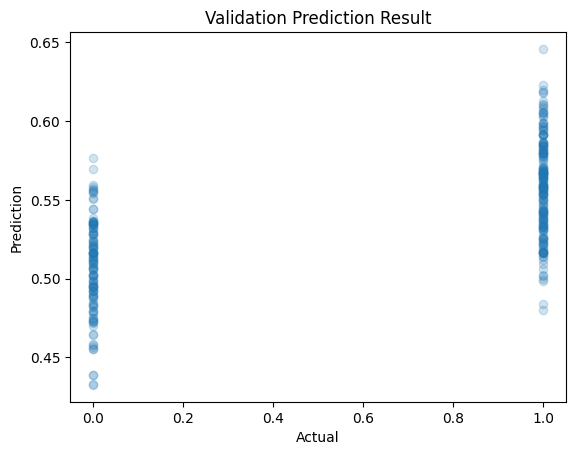

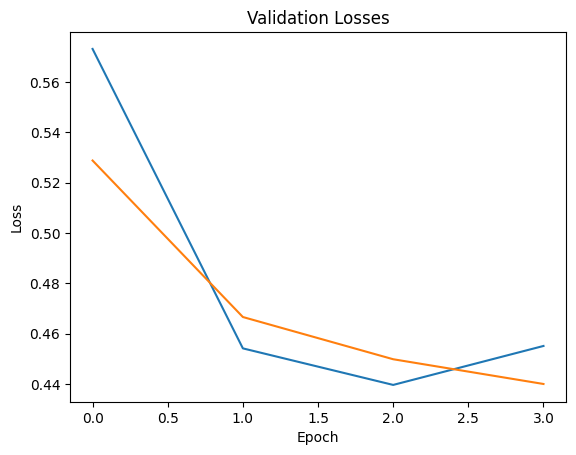

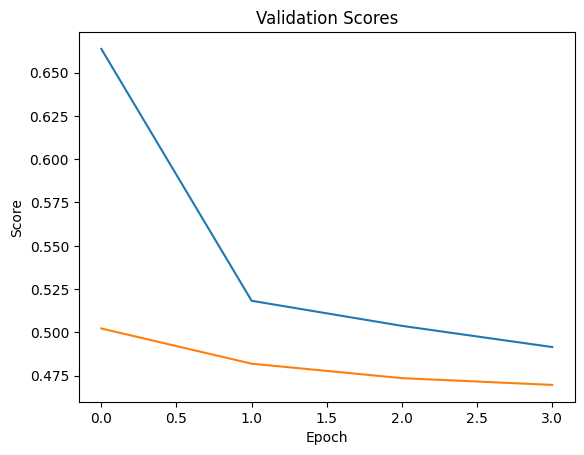

In [29]:
plt.scatter(p_valid['label'],preds, alpha=0.2)
plt.title('Validation Prediction Result')
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.show()

x = np.arange(epochs)
plt.title('Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(x,trainlosses)
plt.plot(x,vallosses)
plt.show()

x = np.arange(epochs)
plt.title('Validation Scores')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.plot(x,trainscores)
plt.plot(x,validscores)
plt.show()

# save model

    bestscores = []
    bestscores.append(bestscore)

    for fold in range(1,5):

        # initializing the data
        p_train = train[train["kfold"]!=fold].reset_index(drop=True)
        p_valid = train[train["kfold"]==fold].reset_index(drop=True)

        train_dataset = BERTDataSet(p_train["text"],p_train["label"])
        valid_dataset = BERTDataSet(p_valid["text"],p_valid["label"])

        train_dataloader = DataLoader(train_dataset,batch_size=train_batch,shuffle = True,num_workers=4,pin_memory=True)
        valid_dataloader = DataLoader(valid_dataset,batch_size=valid_batch,shuffle = False,num_workers=4,pin_memory=True)

        model = transformers.RobertaForSequenceClassification.from_pretrained("roberta-base",num_labels=1)

        model.to(device)
        LR=2e-5
        optimizer = AdamW(model.parameters(), LR,betas=(0.9, 0.999), weight_decay=1e-2) # AdamW optimizer
        train_steps = int(len(p_train)/train_batch*epochs)
        num_steps = int(train_steps*0.1)
        scheduler = get_linear_schedule_with_warmup(optimizer, num_steps, train_steps)

        trainlosses = []
        vallosses = []
        bestscore = None
        trainscores = []
        validscores = []

        for epoch in tqdm(range(epochs)):

            print("---------------" + str(epoch) + "start-------------")

            trainloss,trainscore = training(train_dataloader,model,optimizer,scheduler)
            trainlosses.append(trainloss)
            trainscores.append(trainscore)

            print("trainscore is " + str(trainscore))

            preds,validloss,valscore=validating(valid_dataloader,model)
            vallosses.append(validloss)
            validscores.append(valscore)

            print("valscore is " + str(valscore))

            if bestscore is None:
                bestscore = valscore

                print("Save first model")

                state = {
                                'state_dict': model.state_dict(),
                                'optimizer_dict': optimizer.state_dict(),
                                "bestscore":bestscore
                            }

                torch.save(state, "model" + str(fold) + ".pth")

            elif bestscore > valscore:
                bestscore = valscore
                print("found better point")

                state = {
                                'state_dict': model.state_dict(),
                                'optimizer_dict': optimizer.state_dict(),
                                "bestscore":bestscore
                            }
                torch.save(state, "model"+ str(fold) + ".pth")

            else:
                pass


        bestscores.append(bestscore)

    bestscores

    np.mean(bestscores)
    print("my cv is " + str(np.mean(bestscores)))

# def predicting
not use saved models

In [30]:
def predicting(test_dataloader,model):

    model.to(device)
    model.eval()
    allpreds = []
    preds = []
    allvalloss=0

    with torch.no_grad():
        for a in test_dataloader:

            ids = a["ids"].to(device)
            mask = a["mask"].to(device)

            output = model(ids,mask)
            output = output["logits"].squeeze(-1)
            preds.append(output.cpu().numpy())

        preds = np.concatenate(preds)
        allpreds.append(preds)

    return allpreds

# def predicting2
use saved models

    #model initialized
    model = transformers.RobertaForSequenceClassification.from_pretrained("roberta-base",num_labels=1)

    pthes = [os.path.join("./",s) for s in os.listdir("./") if ".pth" in s]

    def predicting2(
        test_dataloader,
        model,
        pthes
    ):

        allpreds = []    
        for pth in pthes:

            state = torch.load(pth)        
            model.load_state_dict(state["state_dict"])
            model.to(device)
            model.eval()      
            preds = []
            allvalloss=0

            with torch.no_grad():

                for a in test_dataloader:

                    ids = a["ids"].to(device)
                    mask = a["mask"].to(device)

                    output = model(ids,mask)
                    output = output["logits"].squeeze(-1)
                    preds.append(output.cpu().numpy())

                preds = np.concatenate(preds)           
                allpreds.append(preds)

        return allpreds

# Predict

In [31]:
tpreds = predicting(test_dataloader,model)
#tpreds = predicting2(test_dataloader,model,pthes)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

# Prediction Result

In [ ]:
test_pred = []
for p in tpreds[0]:
    test_pred+=[p]

In [32]:
plt.scatter(p_test['label'],test_pred, alpha=0.2)
plt.title('Test Prediction Result')
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.show()

NameError: name 'test_pred' is not defined